# Gen Kitle Veri Çerçevesi İncelemesi

## Veri Çerçevesini Tanımak

veri seti ile ilgili bilgiler

## R için Gerekli Kütüphaneleri Yüklemek

Bu çekirdekte; gen verilerini indirmek, yüklemek, ön işleme tabii tutmak, normalize etmek, filtrelemek ve eksik gen verilerini manipüle etmek gibi pek çok işlemi kolaylıkla gerçekleştireceğimiz R dilini ve kütüphanelerini kullanacağız. Ayrıca R üzerinde gen verileri ile ilgili yapacağımız tüm işlemlerde kullanmamız gereken Bioconductor platformunu ve kütüphanelerini de yükleyerek çekirdeğe dahil ediyoruz.

In [ ]:
BiocManager::install()

In [75]:
library(Biobase)
library(ggplot2)
library(klaR)
library(caret)
library(pROC)
library(C50)
library(partykit)
library(RWeka)
library(pROC)
library(kernlab)
library(CMA)
library(ALL)
library(genefilter)
library(randomForest)
library(org.Hs.eg.db)
library(hgu95av2.db)
library(hgu133plus2.db)
library(affyPLM)
library(impute)
library(GEOquery)

R ile ilgili kullanacağımız kütüphaneleri de yükleyerek çekirdeğe dahil ediyoruz.

## Veri Çerçevelerini Dahil Etmek

Çekirdeğe dahil etmemiz gereken iki veri çerçevesi vardır. Bunlardan ilki gen ifade verilerini içeren binlerce öznitelikten ve örneklemin sayısı kadar gözlemden oluşan veri çerçevesidir. İkincisi ise bu gen verilerini içeren gözlemlerin karşılık bulduğu kanserin kötü veya iyi huylu olduğu, yaşı, cinsiyeti gibi fenotip özelliklerini barındıran veri çerçevesidir.

### Gen Veri Çerçevesini Dahil Etmek

Gen verilerini dahil etmek için getGEO() kütüphanesi kullanılır ve gds nesnesine atanır. Bu nesneyi okunabilir bir ExpressionSet nesnesine dönüştürmek için ise GDS2eSet() fonksiyonu kullanılır.

In [76]:
gds <- getGEO("GDS4456")
eset <- GDS2eSet(gds, do.log2 = TRUE)

Using locally cached version of GDS4456 found here:
C:\Users\Murat\AppData\Local\Temp\Rtmpe48ozr/GDS4456.soft.gz 
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character(),
  IDENTIFIER = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL570 found here:
C:\Users\Murat\AppData\Local\Temp\Rtmpe48ozr/GPL570.annot.gz 
Warning message:
"62 parsing failures.
  row             col           expected    actual         file
54614 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
54615 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
54616 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
54617 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
54618 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
..... ............... .................. ......... ............
See problems(...) for more details.
"

### Fenotip Veri Çerçevesini Dahil Etmek

Dahil etmemiz gereken ikinci veri çerçevesi ise gen veri çerçevesinde bulunan gözlemlere karşılık gelen örneklemin cinsiyetini, iyi veya kötü huylu kitle taşıdığını, yaşu gibi özellikleri barındıran fenotip veri çerçevesidir.

In [77]:
pVeri <- pData(eset)

## Veri Çerçevelerine İlk Bakış

Aşağıda bulunan eset kod çıktısı eset nesnesi hakkında bize yüzeysel temel bilgileri sunar.

In [78]:
eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 54675 features, 93 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM786527 GSM786539 ... GSM786546 (93 total)
  varLabels: sample specimen disease.state description
  varMetadata: labelDescription
featureData
  featureNames: 1007_s_at 1053_at ... AFFX-TrpnX-M_at (54675 total)
  fvarLabels: ID Gene title ... GO:Component ID (21 total)
  fvarMetadata: Column labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 22228636 
Annotation:  

Yarattığımız "eset" nesnesi doğrudan okunabilir değildir, exprs() fonksiyonu ile okunabilir hale getirilir. 

In [79]:
head(exprs(eset))

,GSM786527,GSM786539,GSM786541,GSM786556,GSM786523,GSM786497,GSM786501,GSM786517,GSM786534,GSM786555,...,GSM786494,GSM786504,GSM786510,GSM786514,GSM786516,GSM786520,GSM786521,GSM786536,GSM786542,GSM786546
1007_s_at,3.436602,3.525042,3.564500,3.570426,3.446177,3.303810,3.473008,3.500330,3.492007,3.613178,...,3.162109,3.241979,3.548523,3.408291,3.394075,3.410409,3.224636,3.478351,3.245156,3.223690
1053_at,2.846343,3.110801,2.696606,2.093591,2.465815,2.992203,3.048642,3.029516,2.779632,3.179242,...,3.027223,3.027784,3.066189,3.054428,2.677596,3.305695,3.160625,2.798061,2.457466,2.867968
117_at,1.911550,2.026407,1.759377,2.180154,1.874152,1.927221,1.881488,2.745405,1.849803,1.829362,...,2.066186,2.446828,1.839815,2.068017,2.465123,2.371255,2.258045,2.066186,2.066186,2.060694
121_at,2.459384,2.440599,2.440599,3.486161,2.440599,2.440599,2.440599,2.440599,2.440599,3.028412,...,2.455689,2.620713,2.440599,2.534938,2.440599,2.440599,2.440599,2.440599,2.440599,2.440599
1255_g_at,1.157794,1.157794,1.157794,1.157794,1.157794,1.157794,1.157794,1.157794,1.157794,1.157794,...,1.157794,1.161559,1.157794,1.157794,1.157794,1.201170,1.157794,1.157794,1.157794,1.157794
1294_at,1.479588,2.054529,2.365040,2.425645,1.499486,1.684047,1.681184,1.609930,2.020396,2.738822,...,1.511200,1.524465,1.878949,2.127244,1.610473,1.609930,1.525753,1.536083,1.609930,1.531020


"eset" nesnesinin kaç gözlem ve kaç öznitelikten oluştuğuna bakmak için dim() fonksiyonu kullanılabilir.

In [80]:
dim(eset)

Features  Samples 
   54675       93

Örneklemin 93 kişiyi barındırdığı ve 54.675 adet gen verisinden oluştuğu anlaşılıyor.

Fenotip verinin öznitelik ve gözlemleri hakkında özet bilgileri almak için summary() fonksiyonu kullanılabilir.

In [81]:
summary(pVeri)

       sample        specimen            disease.state description       
 GSM786491: 1   stage pT1:10   no recurrence/DOD:54    Length:93         
 GSM786492: 1   stage pT2:17   recurrence/DOD   :39    Class :character  
 GSM786493: 1   stage pT3:42                           Mode  :character  
 GSM786494: 1   stage pT4:19                                             
 GSM786495: 1   stage pTa: 5                                             
 GSM786496: 1                                                            
 (Other)  :87                                                            

Hedef özniteliğimiz, mesane kanserinin nüksedip nüksetmediğini bize veren "disease.state" özniteliğidir.

In [82]:
head(pVeri)

,sample,specimen,disease.state,description
GSM786527,GSM786527,stage pTa,no recurrence/DOD,Value for GSM786527: 37_pTa; src: Bladder Cancer
GSM786539,GSM786539,stage pTa,no recurrence/DOD,Value for GSM786539: 49_pTa; src: Bladder Cancer
GSM786541,GSM786541,stage pTa,no recurrence/DOD,Value for GSM786541: 51_pTa; src: Bladder Cancer
GSM786556,GSM786556,stage pTa,no recurrence/DOD,Value for GSM786556: 66_pTa; src: Bladder Cancer
GSM786523,GSM786523,stage pTa,recurrence/DOD,Value for GSM786523: 33_pTa; src: Bladder Cancer
GSM786497,GSM786497,stage pT1,no recurrence/DOD,Value for GSM786497: 7_pT1; src: Bladder Cancer


In [83]:
dim(pVeri)

[1] 93  4

Beklenilidği gibi fenotip veri de 93 gözlemden(hastadan) oluşmakta.

# Veri Ön İşleme

## Eksik Verileri İşlemek

Gen veri çerçevemizde eksik veri olup olmadığına bakmak için "eset" nesnesini "exprs( )" fonksiyonu ile açıp "is.na( )" fonksiyonunu kullanabiliriz.

In [84]:
sum(is.na(exprs(eset)))

[1] 0

Gen veri çerçevemizde hiç eksik veri yok. Fenotip veri çerçevemizi de kontrol etmek için aynı yöntemi uygularız.

In [85]:
sum(is.na(pVeri))

[1] 0

Fenotip veri çerçevemizde de hiç eksik veri bulunmamakta. O halde gen verilerini normalize etme ve filtreleme işlemlerine geçebiliriz.

## Gen Verilerini Normalize Etmek

Genelde makine öğrenme algoritmasına sokmadan önce kullanacağımız veri çerçevesindeki gözlem değerlerini normalize ederiz. Normalize etmemizin amacı farklı dünyalardan olan verilerin varyansını bozmadan aynı ölçekte sıkıştırmaktır. Örneğin; kilo, boy ve yaş gibi sayısal öznitelikler birbirlerinden farklı ölçeklerdedir. 

Normalizasyon çeşitleri olarak minimum/maksiumum ölçeklendirme, ondalık ölçeklendirme, z-skor ölçeklendirme gibi pek çok ölçeklendirme çeşidi olsa da biz gen verileri için en uygun gördüğümüz fonksiyonu kullanacağız. Önce gen verilerinin bize normalize halde gelip gelmediğini kontrol etmek için kutu grafiği çizdiriyoruz.

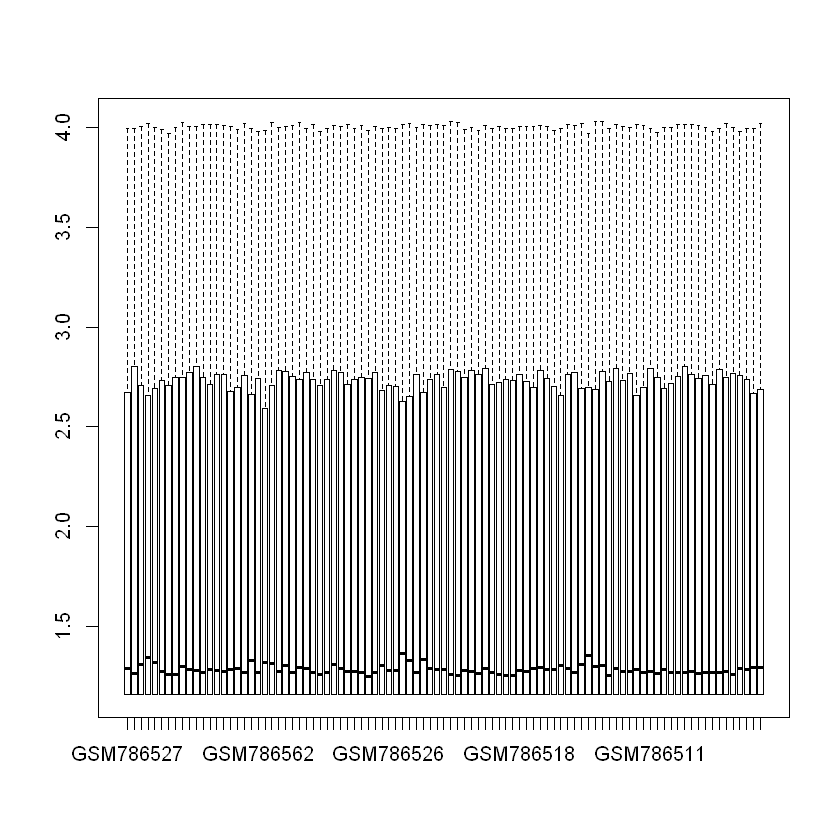

In [86]:
boxplot(eset)

Gen verileri ölçeklendirilmemiş ve doğrudan eset nesnesini normalize( ) fonksiyonu ile ölçeklendiriyoruz.

In [87]:
eset <- normalize(eset)

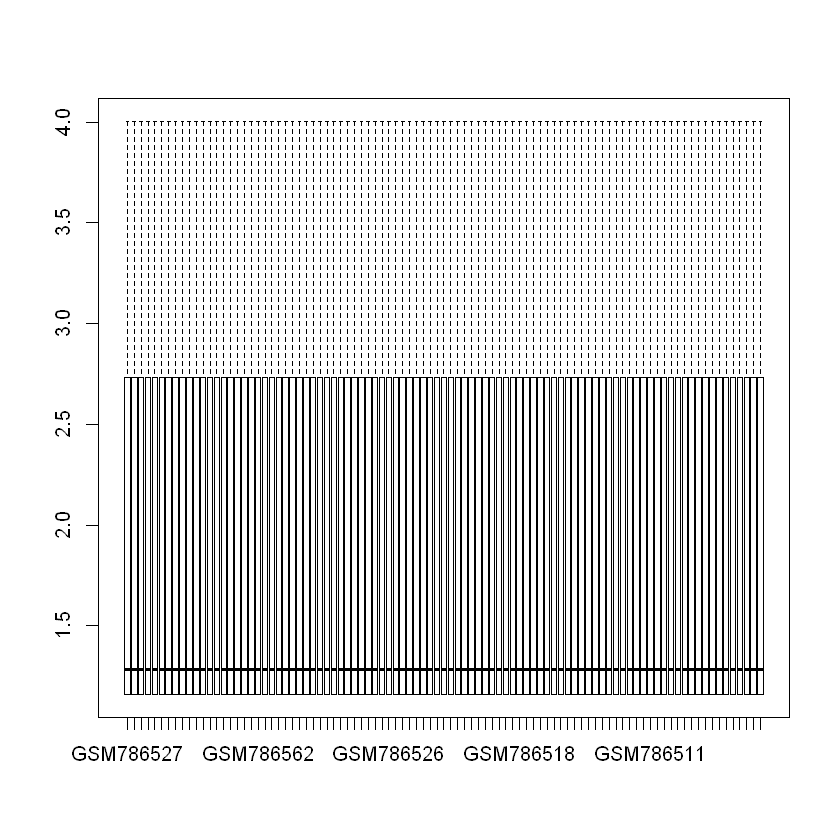

In [88]:
boxplot(eset)

Kontrolü için tekrardan kutu grafik çizdirdiğimizde normalizasyonun başarılı olduğunu görüntüleyebiliriz.

## Gen Verilerini Filtrelemek

Pek çok gen veri çerçevesinin yaklaşık olarak 50.000 öznitelikten oluştuğu biliniyor. Bu kadar fazla öznitelikten oluşan veri çerçevelerini, geliştirdiğimiz makine öğrenmesi modellerine filtrelenmeden soktuğumuzda, bilgisayarların işlem kapasitesini yoran ve günler süren bir eğitim sürecini başlatmış olabiliriz. Özellikle makine öğrenmesi algoritmalarına parametre optimizasyonu yapmak istediğimizde bu normal bir bilgisayar için haftalar sürebilecek derecede uzun ve yorucu bir süreç olabilir.

Ayrıca, her gen verisi modelleme için değerli olmadığı gibi birbilerini tekrarlayan gen verileri de veri çerçevemizde bulunuyor olabilir. Bu durum modelleme için elverişli bir şey olmadığı gibi öznitelik seçimi yaparak gözlemler arasında en az değişiklik gösteren, düşük sinyaller veren öznitelikler filtrelenerek atılabilir.

Veri çerçevesindeki verileri filtrelemek için pek çok seçeneğimiz bulunmaktadır. Söz konusu gen verileri ise  en elverişli tekniğin "geneFilter" paketi içerisinde yer alan "nsFilter( )" fonksiyonu olduğu düşünülmektedir. Gen verilerini filtrelemek için Bioconductor platformunun bize sunduğu bu fonksiyon veri çerçevesinin anotasyon(annotation) paketindeki bilgileri kullanarak ve varyansa göre sıralama yaparak gen verisi tekrarını da önlemeyi amaçlar.

In [89]:
print(annotation(eset))

character(0)


Dahil ettiğimiz eset nesnesinin anotasyon paketinin olup olmadığına bakmak için "annotation( )" fonksiyonunu kullandık ve olmadığını gördük.

In [90]:
annotation(eset) <- "hgu133plus2.db"

Bu yüzden anotasyon olarak Bioconductor platformunun sağladığı açıklama paketini "hgu133plus2.db" atama yapabiliriz. Artık filtreleme için hazırız.

In [91]:
filtrelenmis <- nsFilter(eset)
filtrelenmis <- filtrelenmis$eset

Filtrelendikten sonra gen verilerinin boyutunu tekrardan kontrol ederiz ve gözlemlerin sabit kaldığını, özniteliklerde ise ciddi bir azalma olduğunu görebiliriz.

In [92]:
dim(filtrelenmis)

Features  Samples 
   10091       93

## Hedef Öznitelik Manipülasyon İşlemleri

Fenotip veri çerçevesi içerisinde hedef öznitelik olarak belirlediğimiz "disease.state" değişkenini "factor" tipine çevirerek durum isimli oluşturduğumuz değişkene atarız.

In [93]:
durum <- factor(pData(eset)$disease.state)
head(durum)

[1] no recurrence/DOD no recurrence/DOD no recurrence/DOD no recurrence/DOD
[5] recurrence/DOD    no recurrence/DOD
Levels: no recurrence/DOD recurrence/DOD

Durum değişkenine ait iki kategori bulunmaktadır. Bu kategorileri daha anlaşılır kılmak için yeniden adlandırırız.

In [94]:
levels(durum)[levels(durum)=="no recurrence/DOD"] <- "Normal"
levels(durum)[levels(durum)=="recurrence/DOD"] <- "Kanser"
levels(durum)

[1] "Normal" "Kanser"

Elimizdeki veri çerçevesinin ne kadar dengeli olduğunu sorgulamak için table( ) fonksiyonuna durum değişkenini parametre olarak girebiliriz. Dağılım, dengeli olmadığı gibi tam olarak dengesiz de değildir.

In [95]:
table(durum)

durum
Normal Kanser 
    54     39 

## Modelleme Öncesi Veri Çerçevesini Hazırlama

R ve Bioconductor teknolojilerinin getirdiği kolaylıklarla gen veri çerçevemizi artık modellemeye hazır hale getirmiş sayılırız. Ancak makine öğrenmesi modellemelerini, modellerin parametre optimizasyonlarını, modellerin başarı metriklerini değerlendirme ve skorlama gibi kısımları Python aracılığıyla yapacağımız için veri çerçevesini "csv" olarak yazdırıp Python çekirdeğinde işlemlere devam edeceğiz.

In [97]:
df <- data.frame(t(exprs(filtrelenmis)))
df$durum <- durum

Oluşturduğumuz veri çerçevesi gen verilerinden ibaretti. Son öznitelik olarak durum isminde hedef değişkenimizi de ekledik. Veri çerçevesi 93 gözlem ve 10091 öznitelikten oluşurken durum değişkeni ile birlikte 10092 özniteliğe yükselmiş oldu.

In [113]:
dim(df)

[1]    93 10092

Son haline getirdiğimiz veri çerçevesinde dilediğimiz 7 gözlemi ve 8 özniteliği yazdırıyoruz.

In [116]:
df[24:30,10085:10092]

,X203301_s_at,X201130_s_at,X223596_at,X207223_s_at,X214198_s_at,X222201_s_at,X205241_at,durum
GSM786580,3.397218,1.168577,1.386954,1.276967,3.130278,3.365637,2.538495,Normal
GSM786581,3.267292,1.275972,1.332537,1.730278,3.420391,3.143409,3.257337,Normal
GSM786583,3.443423,1.255108,1.410793,1.686167,3.350143,3.106522,2.877735,Normal
GSM786492,3.412878,1.263399,1.368861,1.157794,3.368400,3.268134,3.086549,Kanser
GSM786493,3.423147,1.848541,1.456441,2.013867,3.406400,3.221872,3.147212,Kanser
GSM786499,3.343821,1.302124,1.245706,1.258994,3.394820,3.138808,2.943549,Kanser
GSM786502,3.220836,2.948273,1.251121,2.416711,3.328583,3.222488,2.665015,Kanser


Veri çerçevesini istediğimiz konumda ve "csv" formatında bir belge haline getirmek için "write.csv( )" fonksiyonunu kullanırız.

In [117]:
write.csv(df, 'df.csv' , row.names = FALSE)